In [2]:
import pandas as pd
import numpy as np 
import json
import re
import pickle
import math
import tqdm
from scipy.spatial import cKDTree
from fuzzywuzzy import fuzz
import pickle
from shapely import wkt
import networkx as nx
from collections import Counter
import geopandas as gpd
from shapely.geometry import Polygon
import transbigdata as tbd
from shapely.wkt import loads
from itertools import combinations
from tqdm import trange
from tqdm import tqdm
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
from contextily import add_basemap
import matplotlib.pyplot as plt
import geopandas
from scipy.stats import pearsonr
from shapely import geometry as geo
from shapely import wkt
from sklearn import metrics
import shapely
import itertools

# 餐馆处理

<!-- 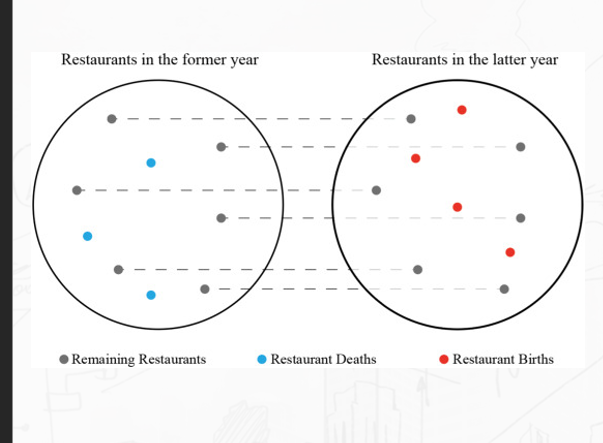 -->
<!-- 头尾年份分别是2015年和2022年，
- 2015年我需要一个描述['remaining', 'death']两种状态的变量life，
- 而2022年是描述['remaing', 'birth']两种状态的变量creation，中间的年份这两个变量都有。
- 我觉得变量中不应该存在None值，应该把其他值都设为相应的状态值 -->

In [7]:
data = pd.read_csv('data/szcg1522.csv')
data.head()

C:\Users\wujlin\AppData\Local\Temp\ipykernel_5960\3093741310.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/szcg1522.csv')


In [28]:
res_counts = data.loc[data['year'] == 2019, 'geometry'].value_counts().reset_index()
items = {}
for g, c in zip(res_counts['geometry'], res_counts['count']):
    items[g] = c

In [33]:
import json

with open('res_counts.json', 'w') as f:
    json.dump(items, f)

我得给每年的数据生成一个存活变量，如果这家餐馆在下一年还在原位置上我会命名为存活（表示仍在这个资源地上存在），如果这家餐馆不在原位置上，那么就把这家餐馆命名为死亡。我需要在同一个位置上，判断这叫店的名称是否改变。这样做会有一些误差，具体的误差未知。需要进一步的测试。


In [8]:
data['name_'] = data['name'].apply(lambda x: str(x))
data['name_length'] = data['name_'].apply(lambda x: len(x))
data['name_length'].value_counts().to_csv('data/length_data.csv')

In [2]:
# 定义地球赤道半径（单位：千米）
R = 6378.137

# 定义将角度转化为弧度的函数
def radians(d):
    return d * np.pi / 180.0


# 定义根据两点经纬度坐标计算直线距离的函数（单位：米）
def get_distance(lon1, lat1, lon2, lat2):
    # 将角度转化为弧度
    rad_lon1 = radians(lon1)
    rad_lat1 = radians(lat1)
    rad_lon2 = radians(lon2)
    rad_lat2 = radians(lat2)
    # 计算两点纬度和经度的差值
    a = rad_lat1 - rad_lat2
    b = rad_lon1 - rad_lon2
    # 根据半正矢公式计算弧长
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a / 2), 2) + math.cos(rad_lat1) * math.cos(rad_lat2) * math.pow(math.sin(b / 2), 2)))
    # 将弧长乘以地球半径，得到直线距离
    s = s * R
    # 将千米转换为米，保留两位小数
    s = round(s * 1000, 2)
    return s




## 我觉得还得加一个距离区间的精度，比如在100m内，寻找最接近的地理对象，并且这个地理对象要在100m内，这样才能进行比较

def get_pair(lefts, rights, distance_thereshold=10):
    '''我们需要获得t1时刻，某一个餐馆在t2时刻内最接近的对象

    :params left_index: 需要进行遍历的t1时刻的餐馆对象的索引
    :param rights: 需要进行比较的t2时刻的餐馆列表
    '''
    tree = cKDTree(rights[['lon', 'lat']].values)
    _, right_indices = tree.query(lefts[['lon', 'lat']].values, k=1)
    test_data = pd.DataFrame(None)
    test_data['lon_1'] = lefts['lon']
    test_data['lat_1'] = lefts['lat']
    test_data['lon_2'] = rights.iloc[right_indices, ]['lon'].to_list()
    test_data['lat_2'] = rights.iloc[right_indices, ]['lat'].to_list()
    distances = test_data.apply(lambda row: get_distance(row[0], row[1], row[2], row[3]), axis = 1).to_list()
    right_indexs = []
    for index, distance in zip(right_indices, distances):
        if distance <= distance_thereshold:
            right_index = index
            right_indexs.append(right_index)
        else:
            right_index = None   # 如果距离不在区间范围内，我将会舍弃这个left，把life变量赋值为None
            right_indexs.append(right_index)
    return right_indexs


def compare_with_character(name1, name2,  prop=0.5):
    '''有个问题，餐馆的名称长短不一，大部分名称在4-10字范围内，我需要根据配对名称的具体长短情况，选择比较的精度

    :params prop：这个也没有什么硬性标准，只能靠测试了
    
    '''
    length_1 = len(name1)
    length_2 = len(name2)
    # 或者我们可以通过设置百分比来计算比较的长度
    if min(length_1, length_2) > 4:
        length = round(min(length_1*prop, length_2*prop))
        char_1 = name1[:length]
        char_2 = name2[:length]
        if char_1 == char_2:
            return 'remaining'
        else:
            return 'death'
    else:
        char_1 = name1[:2]
        char_2 = name2[:2]
        if char_1 == char_2:
            return 'remaining'
        else:
            return 'death'


# 比较名称，判断是否相同
def compare_with_character_life(name1, name2):
    # 使用fuzz.partial_ratio计算字符串相似度
    return 'remaining' if fuzz.partial_ratio(name1, name2) > 90 else 'death'  # 假设相似度大于80%则认为是同一餐馆

# 比较名称，判断是否相同
def compare_with_character_creation(name1, name2):
    # 使用fuzz.partial_ratio计算字符串相似度
    return 'remainning' if fuzz.partial_ratio(name1, name2) > 90 else 'birth'  # 假设相似度大于80%则认为是同一餐馆


def get_pair(lefts, rights, distance_thereshold=50):
    '''我们需要获得t1时刻，某一个餐馆在t2时刻内最接近的对象

    :params left_index: 需要进行遍历的t1时刻的餐馆对象的索引
    :param rights: 需要进行比较的t2时刻的餐馆列表
    '''
    tree = cKDTree(rights[['lon', 'lat']].values)
    _, right_indices = tree.query(lefts[['lon', 'lat']].values, k=1)
    test_data = pd.DataFrame(None)
    test_data['lon_1'] = lefts['lon']
    test_data['lat_1'] = lefts['lat']
    test_data['lon_2'] = rights.iloc[right_indices, ]['lon'].to_list()
    test_data['lat_2'] = rights.iloc[right_indices, ]['lat'].to_list()
    distances = test_data.apply(lambda row: get_distance(row[0], row[1], row[2], row[3]), axis = 1).to_list()
    right_indexs = []
    for index, distance in zip(right_indices, distances):
        if distance <= distance_thereshold:
            right_index = index
            right_indexs.append(right_index)
        else:
            right_index = None   # 如果距离不在区间范围内，我将会舍弃这个left，把life变量赋值为None
            right_indexs.append(right_index)
    return right_indexs


def get_index(polygons, point):
    for i, polygon in enumerate(polygons):
        if point.within(polygon):
            return i


### 对餐馆的生存状况进行分类

In [ ]:
row_data = data.copy()
row_data['life'] = 'death'
row_data.loc[row_data['year'] == 2015, 'life'] = 'None'
# row_data['creation'] = 'birth'
# row_data.loc[row_data['year'] == 2015, 'creation'] = 'None'

In [ ]:
indexs_list = [] # 获取year_next阶段的存活数据
for year in trange(2015, 2022):
    year_start = year
    year_next = year_start + 1
    names_left = row_data.loc[data['year'] == year_start]['name_'].to_list()
    names_right = row_data.loc[data['year'] == year_next]['name_'].to_list()
    data_left = row_data.loc[data['year'] == year_start]
    data_right = row_data.loc[data['year'] == year_next]
    left_indexs = get_pair(data_right, data_left)
    life = []
    indexs = []
    for right_index in range(len(data_right)):
        left_index = left_indexs[right_index]
        if not pd.isna(left_index):
            result = compare_with_character_life(names_left[left_index], names_right[right_index])
            life.append(result)
            indexs.append(left_index)
        else:
            life.append('death') # 如果这个地方在下一年的数据中没找到，那我们就认为它死亡了
    row_data.loc[data['year'] == year_next, 'life'] = life
    indexs_list.append(indexs)


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:51<00:00,  7.29s/it]


In [ ]:
# creation = []
# for year in trange(2015, 2022):
#     year_start = year
#     year_next = year_start + 1
#     dt = row_data.loc[row_data['year'] == year_next]
#     dt = dt.reset_index()
#     dt.loc[indexs_list[year - 2014], 'creation'] = 'remaining'
#     creation.extend(dt['creation'].to_list())

# row_data.loc[row_data['year'] != 2015, 'creation'] = creation

In [ ]:
# for year in trange(2015, 2022):
#     year_start = year
#     year_next = year_start + 1
#     names_left = row_data.loc[data['year'] == year_start]['name_'].to_list()
#     names_right = row_data.loc[data['year'] == year_next]['name_'].to_list()
#     data_left = row_data.loc[data['year'] == year_start]
#     data_right = row_data.loc[data['year'] == year_next]
#     left_indexs = get_pair(data_right, data_left)
#     creation = []
#     indexs = []
#     for right_index in range(len(data_right)):
#         left_index = left_indexs[right_index]
#         if not pd.isna(left_index):
#             result = compare_with_character_creation(names_left[left_index], names_right[right_index])
#             creation.append(result)
#             indexs.append(right_index)
#         else:
#             creation.append('remaining') # 如果该餐馆在上一年没被找到，则认为是新生餐馆
#     row_data.loc[data['year'] == year_next, 'creation'] = creation

In [ ]:
# creation = []
# for year in trange(2015, 2022):
#     year_start = year
#     year_next = year_start + 1
#     dt = row_data.loc[row_data['year'] == year_next]
#     dt = dt.reset_index()
#     dt.loc[indexs_list[year - 2014], 'creation'] = 'remaining'
#     creation.extend(dt['creation'].to_list())

# row_data.loc[row_data['year'] != 2015, 'creation'] = creation

In [ ]:
# 将life数据和creation数据进行合并
row_data['states'] = row_data['life']
# row_data.loc[(row_data['life'] == 'death')&(row_data['creation'] == 'birth'), 'states'] = 'birth'
# row_data.loc[(row_data['life'] == 'death') &(row_data['creation'] == 'remaining'), 'states'] = 'death'
row_data = row_data.iloc[:, 1:]
#row_data = row_data.loc[row_data['year'] != 2022, ]
row_data = row_data.loc[row_data['year'] != 2015, ]

In [ ]:
# with open('data/row_data_new_1', 'wb') as f:
#     f.write(pickle.dumps(row_data))

In [ ]:
with open('data/row_data_new_1', 'rb') as f:
    row_data = pickle.load(f)

In [ ]:
dt = row_data.groupby('year')['states'].value_counts().reset_index()
dt['sum'] = sum([[x] * 2 for x in dt.groupby(['year']).agg({'count':['sum']}).iloc[:, 0].to_list()], [])
dt['rate'] = dt['count'] / dt['sum']
dt = dt.pivot(index='year', columns='states', values='rate').reset_index()

In [ ]:
dt

states,year,death,remaining
0,2016,0.852756,0.147244
1,2017,0.608109,0.391891
2,2018,0.410758,0.589242
3,2019,0.591077,0.408923
4,2020,0.752994,0.247006
5,2021,0.679947,0.320053
6,2022,0.612534,0.387466


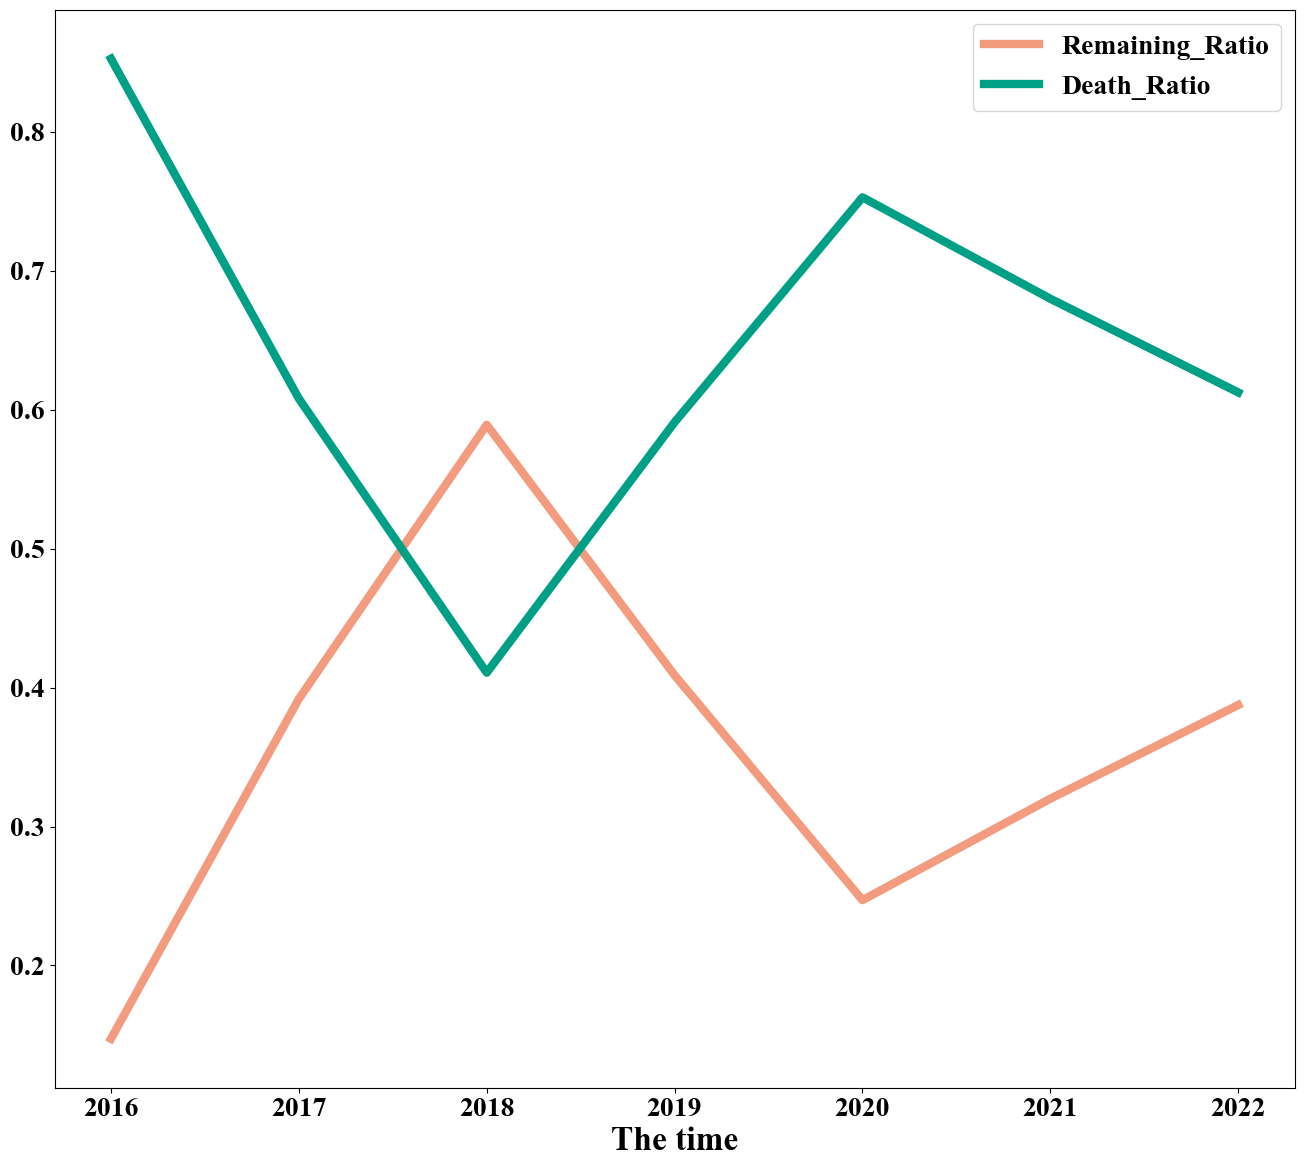

In [ ]:
# 对这些观测数据进行可视化
plt.rc('font', family='Times New Roman') # 设置全局字体为times-newroman
plt.rcParams['font.size'] = 20 # 设置字体大小
plt.rcParams['font.weight'] = 'bold' # 设置字体粗细

i_color = '#E64B35'
r_color = '#F39B7F'
d_color = '#00A087'
b_color = '#3C5488'
zeta = np.linspace(0, 1, 10)[:-1]

plt.figure(figsize=(16, 14))
plt.subplot(111)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
# plt.plot(dt['year'], results['i_rate'], color = i_color, label = 'Infection_Ratio_Y', linewidth = 6)
plt.plot(dt['year'], dt['remaining'], color = r_color, label = 'Remaining_Ratio', linewidth = 6)
plt.plot(dt['year'], dt['death'], color = d_color, label = 'Death_Ratio', linewidth = 6)
#plt.plot(dt['year'], dt['birth'], color = b_color, label = 'Birth_Ratio', linewidth = 6)
# plt.title('折线图')
plt.xlabel('The time', fontdict={'weight':'bold', 'size':24})
plt.legend()
plt.show()
# 还需要添加坐标轴title

In [ ]:
# for year in range(2015, 2022):
#     dt = row_data.loc[row_data['year'] == year, 'life'].value_counts()
#     death_rate = dt['death'] / (dt['death'] + dt['remaining'])
#     print(f'{year}年餐馆死亡率：{death_rate}')
# for year in range(2016, 2023):
#     dt = row_data.loc[row_data['year'] == year, 'creation'].value_counts()
#     #print(dt)
#     death_rate = (dt['birth']) / (dt['birth'] + dt['remaining'])
#     print(f'{year}年餐馆新生率：{death_rate}')

2015年餐馆死亡率：0.697109156610077
2016年餐馆死亡率：0.5409092558325169
2017年餐馆死亡率：0.4374586205849303
2018年餐馆死亡率：0.5421010476404062
2019年餐馆死亡率：0.7156678605748231
2020年餐馆死亡率：0.6618915886404085
2021年餐馆死亡率：0.7440391868273388


## 建立餐馆网络

In [16]:
with open('data/row_data_new_1', 'rb') as f:
    row_data = pickle.load(f)

with open('data/geom_dict_layery', 'rb') as f:
    geom_dict_layery = pickle.load(f)


In [20]:
dt_2019 = row_data.loc[row_data['year'] == 2019,]
dt_2019 = dt_2019.reset_index(drop = True)
dt_2019.head()

In [ ]:
polygons = [loads(p) for p in list(geom_dict_layery.keys())]
points = [loads(p) for p in dt_2019['geometry'].to_list()]
dt_2019['points'] = points
dt_2019['geom_index'] = dt_2019['points'].apply(lambda point: get_index(polygons, point))

In [25]:
# with open('data/dt_2019', 'wb') as f:
#     f.write(pickle.dumps(dt_2019))
# with open('data/dt_2019_mini', 'wb') as f:
#     f.write(pickle.dumps(dt_2019_mini))

In [18]:
# 用所有的poi来生成网络
coordinates = np.column_stack((dt_2019['points'].apply(lambda p: p.x), dt_2019['points'].apply(lambda p: p.y)))
cells, generators = voronoi_frames(coordinates, clip="convex hull")
delaunay = weights.Rook.from_dataframe(cells)

# 导出网络
delaunay_graph = delaunay.to_networkx()
# 添加栅格单元
for node in delaunay_graph.nodes(): 
    delaunay_graph.nodes[node]['geom'] = dt_2019['geom_index'].to_list()[node]

d:\miniconda\miniconda\envs\ordinary\lib\site-packages\libpysal\cg\voronoi.py:173: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  region_df["geometry"] = [Polygon(vertices[region]) for region in regions]
d:\miniconda\miniconda\envs\ordinary\lib\site-packages\libpysal\cg\voronoi.py:176: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geom

In [3]:
# indexs = dt_2019['geom_index'].value_counts().index.to_list()
# item = {}

# for index in indexs:

#     try:
#         grid = dt_2019.loc[dt_2019['geom_index'] == index, ]
#         coordinates = np.column_stack((grid['points'].apply(lambda p: p.x), grid['points'].apply(lambda p: p.y)))
#         cells, generators = voronoi_frames(coordinates, clip="convex hull")
#         delaunay = weights.Rook.from_dataframe(cells)

#         # 导出网络
#         delaunay_graph = delaunay.to_networkx()
#         item[index] = delaunay_graph
#     except:
#         pass

In [30]:
with open('geom_dict_layery', 'rb') as f:
    geom_dict_y = pickle.load(f)

with open('geom_dict_layerx', 'rb') as f:
    geom_dict_x = pickle.load(f)

with open('res_states_', 'rb') as f:
    res_states = pickle.load(f)


### 通过geom_dict_y 和geom_dict_x 把res_states_搬到新的layerX上

In [27]:
geom_x_state = {}
for key1, value1 in res_states.items():
    for key2, value2 in geom_dict_y.items():
        if key1 == value2:
            geom_x_state[key2] = value1

In [29]:
state_layerx = {}
for k1, v1 in geom_x_state.items():
    for k2, v2 in geom_dict_x.items():
        if k1 == k2:
            state_layerx[v2] = v1

In [32]:
state_layerx

{938: {'death': 102, 'remaining': 28, 'birth': 56},
 324: {'death': 59, 'remaining': 21, 'birth': 39},
 972: {'death': 121, 'remaining': 75, 'birth': 89},
 349: {'death': 29, 'remaining': 8, 'birth': 17},
 64: {'death': 54, 'remaining': 13, 'birth': 19},
 1390: {'death': 173, 'remaining': 120, 'birth': 133},
 911: {'death': 114, 'remaining': 61, 'birth': 73},
 234: {'death': 908, 'remaining': 372, 'birth': 553},
 988: {'death': 10, 'remaining': 8, 'birth': 9},
 48: {'death': 59, 'remaining': 21, 'birth': 31},
 318: {'death': 3, 'remaining': 2, 'birth': 3},
 352: {'death': 36, 'remaining': 13, 'birth': 21},
 1365: {'death': 84, 'remaining': 42, 'birth': 50},
 969: {'death': 64, 'remaining': 22, 'birth': 36},
 529: {'death': 19, 'remaining': 2, 'birth': 47},
 84: {'death': 42, 'remaining': 14, 'birth': 22},
 1095: {'death': 148, 'remaining': 51, 'birth': 93},
 649: {'death': 2, 'remaining': 414, 'birth': 1},
 688: {'death': 109, 'remaining': 3, 'birth': 201},
 819: {'death': 65, 'remaini

In [ ]:
# geom_indexs = []
# for i in trange(len(points)):
#     index = get_index(polygons, points[i])
#     geom_indexs.append(index)

In [16]:
with open('data/geom_dict_layery', 'rb') as f:
    geom_dict_layery = pickle.load(f)

with open('data/res_states_', 'rb') as f:
    res_states = pickle.load(f)

In [22]:
keys = res_states.keys()
print(f'最后保留{len(keys)}个栅格')

最后保留1538个栅格


In [23]:
geom_dict_ = {value: key for key, value in geom_dict_layery.items()}

In [24]:
geoms = []
for key in keys:
    geoms.append(geom_dict_[key])

In [149]:
## 我需要根据筛选过后的key_index，来筛选出layerX_restaurant
with open('layerX_restaurant', 'rb') as f:
    layer_x = pickle.load(f)

In [154]:
ls = layer_x[['SourceNode', 'TargetNode']].apply(lambda row: (row[0] in keys) & (row[1] in keys), axis = 1)
layer_x.loc[ls, ]

## 建立病毒网络

In [29]:
df = pd.read_csv('data/sznw19q4.csv')

In [31]:
df['D'] = df['geometry_D'].apply(lambda x: wkt.loads(x).centroid.wkt)
ls = df['D'].to_list()
s = [str(x).split(' ') for x in ls]
lon = [i[1][1:] for i in s]
lat = [i[2][:-1] for i in s]
df['D_lon'] = lon
df['D_lat'] = lat
# df.D_lon.astype(float)
# df.D_lat.astype(float)

In [32]:
df['O'] = df['geometry_O'].apply(lambda x: wkt.loads(x).centroid.wkt)
ls = df['O'].to_list()
s = [str(x).split(' ') for x in ls]
lon = [i[1][1:] for i in s]
lat = [i[2][:-1] for i in s]
df['O_lon'] = lon
df['O_lat'] = lat
df.O_lon.astype(float)
df.O_lat.astype(float)

,Unnamed: 0,time,count,lon_geohash_O,lat_geohash_O,lon_geohash_D,lat_geohash_D,geometry_D,geometry_O,D,D_lon,D_lat,O,O_lon,O_lat
0,0,2019q4,1,113.889771,22.447815,113.867798,22.491760,"POLYGON ((113.8623046875 22.489013671875, 113....","POLYGON ((113.88427734375 22.445068359375, 113...",POINT (113.8677978515625 22.49176025390625),113.8677978515625,22.49176025390625,POINT (113.8897705078125 22.44781494140625),113.8897705078125,22.44781494140625
1,1,2019q4,5,113.845825,22.497253,113.867798,22.491760,"POLYGON ((113.8623046875 22.489013671875, 113....","POLYGON ((113.84033203125 22.4945068359375, 11...",POINT (113.8677978515625 22.49176025390625),113.8677978515625,22.49176025390625,POINT (113.8458251953125 22.49725341796875),113.8458251953125,22.49725341796875
2,2,2019q4,3,113.878784,22.469788,113.867798,22.491760,"POLYGON ((113.8623046875 22.489013671875, 113....","POLYGON ((113.873291015625 22.467041015625, 11...",POINT (113.8677978515625 22.49176025390625),113.8677978515625,22.49176025390625,POINT (113.8787841796875 22.46978759765625),113.8787841796875,22.46978759765625
3,3,2019q4,9,113.878784,22.475281,113.867798,22.491760,"POLYGON ((113.8623046875 22.489013671875, 113....","POLYGON ((113.873291015625 22.4725341796875, 1...",POINT (113.8677978515625 22.49176025390625),113.8677978515625,22.49176025390625,POINT (113.8787841796875 22.47528076171875),113.8787841796875,22.47528076171875
4,4,2019q4,6,113.889771,22.458801,113.867798,22.491760,"POLYGON ((113.8623046875 22.489013671875, 113....","POLYGON ((113.88427734375 22.4560546875, 113.8...",POINT (113.8677978515625 22.49176025390625),113.8677978515625,22.49176025390625,POINT (113.8897705078125 22.45880126953125),113.8897705078125,22.45880126953125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702827,702827,2019q4,1,114.329224,22.716980,114.329224,22.716980,"POLYGON ((114.32373046875 22.7142333984375, 11...","POLYGON ((114.32373046875 22.7142333984375, 11...",POINT (114.3292236328125 22.71697998046875),114.3292236328125,22.71697998046875,POINT (114.3292236328125 22.71697998046875),114.3292236328125,22.71697998046875
702828,702828,2019q4,1,114.021606,22.574158,114.021606,22.574158,"POLYGON ((114.01611328125 22.5714111328125, 11...","POLYGON ((114.01611328125 22.5714111328125, 11...",POINT (114.0216064453125 22.57415771484375),114.0216064453125,22.57415771484375,POINT (114.0216064453125 22.57415771484375),114.0216064453125,22.57415771484375
702829,702829,2019q4,1,113.988647,22.513733,113.988647,22.513733,"POLYGON ((113.983154296875 22.510986328125, 11...","POLYGON ((113.983154296875 22.510986328125, 11...",POINT (113.9886474609375 22.51373291015625),113.9886474609375,22.51373291015625,POINT (113.9886474609375 22.51373291015625),113.9886474609375,22.51373291015625
702830,702830,2019q4,1,113.911743,22.826843,113.911743,22.826843,"POLYGON ((113.90625 22.8240966796875, 113.9062...","POLYGON ((113.90625 22.8240966796875, 113.9062...",POINT (113.9117431640625 22.82684326171875),113.9117431640625,22.82684326171875,POINT (113.9117431640625 22.82684326171875),113.9117431640625,22.82684326171875


In [33]:
# with open('data/communication', 'wb') as f:
#     f.write(pickle.dumps(df))

In [25]:
ls = df[['geometry_D', 'geometry_O']].apply(lambda row: (row[0] in geoms) & (row[1] in geoms), axis = 1)

df_x = df.loc[ls, ]
origin = df_x['geometry_O'].to_list()
destination = df_x['geometry_D'].to_list()
weight = df_x['count'].to_list()
G = nx.DiGraph()
for o, d, w in zip(origin, destination, weight):
    G.add_edge(o, d, weight = w)
UG = G.to_undirected()
# counter = Counter()
# for u,v,a in G.edges(data=True):
#     # 以下两个组合的值是相同的
#     counter[(u,v)] += a['weight']
#     counter[(v,u)] += a['weight']
# for u,v,a in UG.edges(data=True):
#     a['weight'] = counter[(u,v)] # or use sum instead of average


In [214]:
UG_edges_list = list(UG.edges(data=True))
UG_edges_weight_dict = {}
for i in range(len(UG_edges_list)):
    UG_edges_weight_dict[geom_dict_x[UG_edges_list[i][0]], geom_dict_x[UG_edges_list[i][1]]] = UG_edges_list[i][2]['weight']

这段代码里counter的工作原理是：

- 首先，遍历有向网络G中的所有边和它们的数据，每一条边都有两个节点u和v，以及一个字典a，其中包含了边的权重。
- 然后，把每一条边的权重加到counter对象中对应的键(u,v)和(v,u)上。这样就可以统计每一对节点之间的边的权重之和。
- 例如，如果有一条边(1,2)的权重是3，那么counter[(1,2)]和counter[(2,1)]都会增加3。如果有另一条边(2,1)的权重是5，那么counter[(1,2)]和counter[(2,1)]都会再增加5。最后counter[(1,2)]和counter[(2,1)]的值都是8。


In [ ]:
# layerX = []

# for key, value in UG_edges_weight_dict.items():
#     item = {} #注意item应该放在循环里边进行创建
#     item['SourceNode'] = key[0]
#     item['TargetNode'] = key[1]
#     item['Weight'] = value
#     item['SourceLayer'] = 'restaurant'
#     item['TargetLayer'] = 'restaurant'
#     layerX.append(item)

In [19]:
layerY = []

for key, value in UG_edges_weight_dict.items():
    item = {} #注意item应该放在循环里边进行创建
    item['SourceNode'] = key[0]
    item['TargetNode'] = key[1]
    item['Weight'] = value
    item['SourceLayer'] = 'mobility'
    item['TargetLayer'] = 'mobility'
    layerY.append(item)

# 建立耦合网络

In [3]:
with open('data/dt_2019', 'rb') as f:
    dt_2019 = pickle.load(f)

with open('data/communication', 'rb') as f:
    df = pickle.load(f)

with open('data/dt_2019_mini', 'rb') as f:
    dt_2019_mini = pickle.load(f)

In [4]:
dt_2019_mini.head()

,name,type,adname,adcode,typecode,address,lon,lat,geometry,year,name_,name_length,life,states,points,geom_index
82768,丰源美食(华盛路),餐饮服务;中餐厅;中餐厅,龙华区,440309.0,50100,华盛路26号附近,113.999495,22.679423,POINT (113.999495248923 22.6794232218999),2019,丰源美食(华盛路),9,remaining,remaining,POINT (113.999495248923 22.6794232218999),2318.0
155387,高筑墙羊肉串(白石洲店),餐饮服务;餐饮相关场所;餐饮相关,南山区,440305.0,50000,白石街与石洲中路交叉口东北50米,113.962037,22.539492,POINT (113.962037165944 22.53949198917409),2019,高筑墙羊肉串(白石洲店),12,death,death,POINT (113.962037165944 22.53949198917409),1233.0
45763,原味汤粉王,餐饮服务;中餐厅;中餐厅,龙岗区,440307.0,50100,丰茂街与育文路交叉口西50米,114.323987,22.770229,POINT (114.323986732325 22.77022919959781),2019,原味汤粉王,5,remaining,remaining,POINT (114.323986732325 22.77022919959781),1566.0
124409,源之味土菜馆,餐饮服务;中餐厅;中餐厅,龙岗区,440307.0,50100,白石塘子美街31号,114.297030,22.782347,POINT (114.297030119436 22.7823474436618),2019,源之味土菜馆,6,remaining,remaining,POINT (114.297030119436 22.7823474436618),2530.0
89098,深圳动元健康管理中心,餐饮服务;餐饮相关场所;餐饮相关,南山区,440305.0,50000,半岛城邦会所,113.928251,22.481600,POINT (113.928250608087 22.4816001692254),2019,深圳动元健康管理中心,10,death,death,POINT (113.928250608087 22.4816001692254),1634.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130248,野食,餐饮服务;餐饮相关场所;餐饮相关,南山区,440305.0,50000,塘益路43-24号,113.981866,22.592285,POINT (113.981866336623 22.5922853443586),2019,野食,2,death,death,POINT (113.981866336623 22.5922853443586),408.0
99475,鹿角巷,餐饮服务;餐饮相关场所;餐饮相关,光明区,440311.0,50000,元山路6-1号,113.886146,22.787955,POINT (113.88614610162 22.78795520207661),2019,鹿角巷,3,death,death,POINT (113.88614610162 22.78795520207661),2166.0
62790,川风蜀味小吃店,餐饮服务;中餐厅;中餐厅,福田区,440304.0,50100,振兴路华美大厦304栋楼下31-2,114.086063,22.549127,POINT (114.086063284145 22.54912702677951),2019,川风蜀味小吃店,7,remaining,remaining,POINT (114.086063284145 22.54912702677951),995.0
154346,岳阳楼(燕川店),餐饮服务;中餐厅;湖南菜(湘菜),宝安区,440306.0,50108,朗西路52号附近,113.854501,22.797961,POINT (113.854501474929 22.7979611735264),2019,岳阳楼(燕川店),8,remaining,remaining,POINT (113.854501474929 22.7979611735264),240.0


In [10]:
dt_2019_mini = dt_2019.loc[np.random.choice(range(len(dt_2019)), size=12000), ]

In [9]:
dt_2019 = dt_2019.drop_duplicates(subset = 'points')

# with open('data/dt_2019_mini', 'wb') as f:
#     f.write(pickle.dumps(dt_2019_mini_copy))

dt_2019.shape

(171780, 16)

In [8]:
# with open('data/dt_2019_mini', 'rb') as f:
#     dt_2019_mini = pickle.load(f)

In [10]:
# D_list_x = df_x['geometry_D'].to_list()
# O_list_x = df_x['geometry_O'].to_list()
# nodes_list_x = list(set(D_list_x + O_list_x))
# len(nodes_list_x)
D_list_y = df['geometry_D'].to_list()
O_list_y = df['geometry_O'].to_list()
nodes_list_y = list(set(D_list_y + O_list_y))

2609

In [178]:
# pairs = combinations(range(len(nodes_list)), 2)
# dist_dict = {}

In [11]:
nodes_list_x = dt_2019['points'].to_list()
states = dt_2019['states'].to_list()

In [13]:
# 对nodes_list_x继续存储
index_point_dict = {}
index_state_dict = {}
for i in range(len(nodes_list_x)):
    point = nodes_list_x[i]
    index_point_dict[i] = point
    index_state_dict[i] = states[i]


# with open('data/index_point_dict', 'wb') as f:
#     f.write(pickle.dumps(index_point_dict))

# with open('data/index_state_dict', 'wb') as f:
#     f.write(pickle.dumps(index_state_dict))

In [14]:
point_index_dict = {}
for k, v in index_point_dict.items():
    point_index_dict[v] = k

# with open('data/point_index_dict', 'wb') as f:
#     f.write(pickle.dumps(point_index_dict))

In [16]:
with open('data/geom_dict_layery', 'rb') as f:
    geom_dict_y = pickle.load(f)

nodes_list_y = list(geom_dict_y.keys())
len(nodes_list_y)

2609

In [21]:
# 导入itertools模块
# import itertools
# # 使用product函数，对两个向量进行排列组合，每个组合包含两个元素
# pairs = list(itertools.product(range(len(nodes_list_x)), range(len(nodes_list_y))))
dist_dict_layerz = {}

In [5]:
dist_dict_layerz = {}
i = 0
for node_x, node_y in itertools.product(nodes_list_x, nodes_list_y):
    i += 1
    geom_1 = node_x
    geom_2 = shapely.wkt.loads(node_y)
    distance = geom_1.distance(geom_2)
    if distance < 5000:
        index_1 , index_2 = point_index_dict[node_x], geom_dict_y[node_y]
        dist_dict_layerz.setdefault((index_1, index_2), 1)

    if i % 100000 == 0:
        print(f'已处理完{i}条数据')


In [4]:
i = 0
for node_x in nodes_list_x:
    for node_y in nodes_list_y:
        i += 1
        geom_1 = node_x
        lon_1 = geom_1.x
        lat_1 = geom_1.y

        geom_2 = node_y
        centroid_2 = loads(geom_2).centroid.wkt
        lon_2 = float(str(centroid_2).split(' ')[1][1:])
        lat_2 = float(str(centroid_2).split(' ')[2][:-1])

        distance = tbd.getdistance(lon_1, lat_1, lon_2, lat_2)
        if distance < 5000:
            index_1 , index_2 = point_index_dict[node_x], geom_dict_y[node_y]
            dist_dict_layerz[(index_1, index_2)] = 1

        if i % 100000 == 0:
            print(f'已处理完{i}条数据')

In [23]:
dist_dict_layerz

{(0, 0): 17116.354983639092,
 (0, 1): 9329.992082142759,
 (0, 2): 20829.076487667335,
 (0, 3): 4242.478501606731,
 (0, 4): 18144.8610009477,
 (0, 5): 33907.61593017037,
 (0, 6): 17359.73480579774,
 (0, 7): 20363.42358137636,
 (0, 8): 5188.992488115269,
 (0, 9): 18582.871088783206,
 (0, 10): 25949.3089198999,
 (0, 11): 7124.204901264874,
 (0, 12): 10051.848647464192,
 (0, 13): 19271.015612051935,
 (0, 14): 31709.675684602218,
 (0, 15): 28945.584981597956,
 (0, 16): 25524.226877241657,
 (0, 17): 18806.721068596624,
 (0, 18): 35032.08347624584,
 (0, 19): 8120.771794978664,
 (0, 20): 10130.001954241074,
 (0, 21): 33837.36822801118,
 (0, 22): 9031.288022054649,
 (0, 23): 6090.1927898318145,
 (0, 24): 19622.479576293088,
 (0, 25): 23681.9510021667,
 (0, 26): 34997.22622771784,
 (0, 27): 35011.84578626655,
 (0, 28): 13507.75104018956,
 (0, 29): 24260.139309798964,
 (0, 30): 7319.674874198056,
 (0, 31): 31080.071678246553,
 (0, 32): 53946.96328851022,
 (0, 33): 22894.198057478287,
 (0, 34): 25

In [27]:
# with open('data/dist_dict_layerz', 'wb') as f:
#     f.write(pickle.dumps(dist_dict_layerz))

In [3]:
with open('data/dist_dict_layerz', 'rb') as f:
    dist_dict_layerz = pickle.load(f)

In [4]:
# between_dict = dist_dict_layerz.copy()
for key, value in dist_dict_layerz.items():
    dist_dict_layerz[key] = float(np.where(value < 5000, 1, 0))  # 我们把距离阈值设为5km

In [5]:
layerZ = []

for key, value in dist_dict_layerz.items():
    item = {} #注意item应该放在循环里边进行创建
    item['SourceNode'] = key[0]
    item['TargetNode'] = key[1]
    item['Weight'] = value
    item['SourceLayer'] = 'restaurant'
    item['TargetLayer'] = 'mobility'
    layerZ.append(item)

In [6]:
# with open('data/layerZ_coupling_new', 'wb') as f:
#     f.write(pickle.dumps(pd.DataFrame(layerZ)))

In [209]:
# layers = pd.concat([layerX, layerY, layerZ])

In [187]:
# with open('layers', 'wb') as f:
#     f.write(pickle.dumps(layers))

## 对Y网络和X网络的初始值进行设定

In [30]:
risk_area = pd.read_csv('data/processed_risk_area.csv', encoding='gbk')

In [57]:
lst = []
for s in risk_area['polygon'].to_list():
    lst.append([tuple(map(float,p.split(","))) for p in s.split(";")])

In [71]:
polys = [geo.Polygon(ls) for ls in lst]

In [67]:
geom_layery = list(geom_dict_layery.keys())
geom_layery = [wkt.loads(geom) for geom in geom_layery]

In [68]:
layery_risk = []
for geom in geom_layery:
    if sum([geom.intersects(poly) for poly in polys]) > 0:
        layery_risk.append(0)
    else:
        layery_risk.append(1)

In [72]:
# with open('risk_layer_y', 'wb') as f:
#     f.write(pickle.dumps(layery_risk))

In [9]:
# with open('data/state_layerx_new','wb') as f:
#     f.write(pickle.dumps(dt_2019_mini['states'].to_list()))